# Trabajo Práctico Nº 2 - Clustering - KMeans
***

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from sklearn.cluster import KMeans

In [139]:
def rgb_to_hsv(rgb: list) -> list:
    '''
    Función que recibe una lista de 3 listas correspondientes a los canales de colores RGB.
    Devuelve una lista de 3 listas correspondientes a los análogos en color HSV.
    '''
    
    input_shape = rgb.shape
    rgb = rgb.reshape(-1, 3)
    r, g, b = rgb[:, 0], rgb[:, 1], rgb[:, 2]

    maxc = np.maximum(np.maximum(r, g), b)
    minc = np.minimum(np.minimum(r, g), b)
    v = maxc

    deltac = maxc - minc
    s = deltac / maxc
    deltac[deltac == 0] = 1  # to not divide by zero (those results in any way would be overridden in next lines)
    rc = (maxc - r) / deltac
    gc = (maxc - g) / deltac
    bc = (maxc - b) / deltac

    h = 4.0 + gc - rc
    h[g == maxc] = 2.0 + rc[g == maxc] - bc[g == maxc]
    h[r == maxc] = bc[r == maxc] - gc[r == maxc]
    h[minc == maxc] = 0.0

    h = (h / 6.0) % 1.0
    res = np.dstack([h, s, v])
    
    return res.reshape(input_shape)

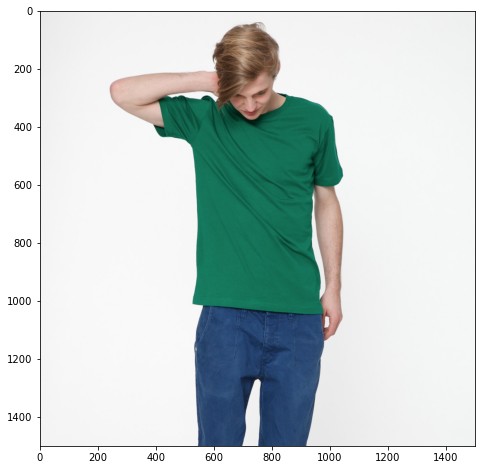

In [140]:
file = 'HDverdesgris.jpg'
# file = 'DSC01535.JPG'
foto = image.imread(file)

plt.figure(figsize=(12, 8))
plt.imshow(foto)

In [141]:
print(f'Cantidad de píxeles: {foto.shape[0]*foto.shape[1]*foto.shape[2]:,d}')

Cantidad de píxeles: 6,750,000


Como la foto es muy grande vamos a trabajar con un *downsampleo* para reducir el tiempo de ejecución.

In [142]:
dsamp = 15
# El slice ::dsamp significa "agarrá todo cada 15 unidades", es decir, agarra 0, 15, 30, ...
# Eso lo hace en X y en Y para los 3 canales
foto_red = foto[::dsamp, ::dsamp, :]
print(f'Cantidad de píxeles: {foto_red.shape[0]*foto_red.shape[1]*foto_red.shape[2]:,d}')

Cantidad de píxeles: 30,000


Vamos a pasar la imagen, que está en RGB a un formato HSV que se supone da mejores resultados a la hora de poder aplicar clusterización

In [143]:
foto_hsv = rgb_to_hsv(foto_red)

# Acá separo los resultados para los distintos parámetros
H = foto_hsv[:,:,0]
S = foto_hsv[:,:,1]
V = foto_hsv[:,:,2]

Y acá vamos a ver, solo para tener una idea, cómo se ven los canales por separado

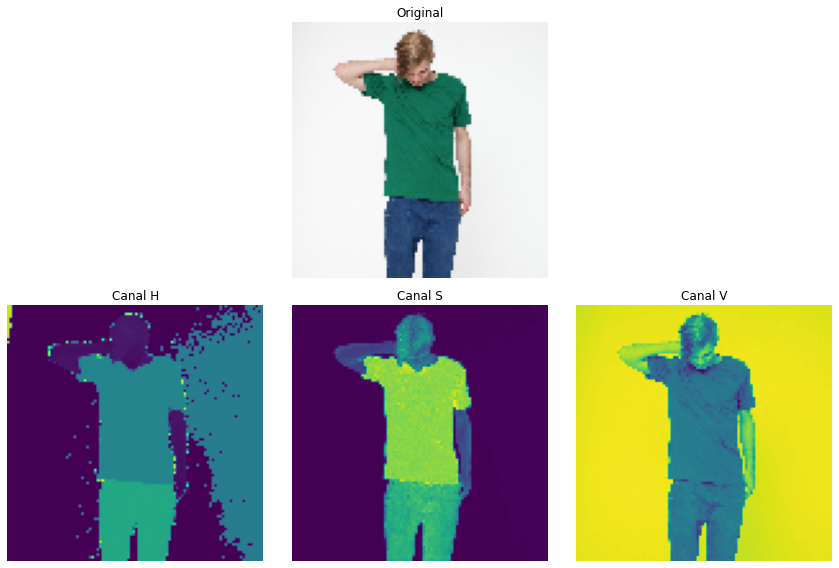

In [144]:
fig1 = plt.figure(figsize=(12, 8))
ax1 = fig1.add_subplot(2, 1, 1)
ax1.imshow(foto_red)
ax1.set_axis_off()

canales = [H, S, V]
for n, canal in enumerate(canales, start=4):
    fig1.add_subplot(2, 3, n).imshow(canal)

ax_list = fig1.axes
ax_list[0].set_title('Original')
ax_list[0].set_axis_off()
ax_list[1].set_title('Canal H')
ax_list[1].set_axis_off()
ax_list[2].set_title('Canal S')
ax_list[2].set_axis_off()
ax_list[3].set_title('Canal V')
ax_list[3].set_axis_off()

plt.tight_layout()

In [145]:
fil, col = np.shape(V)
print(f'{fil} filas, {col} columnas')

100 filas, 100 columnas


La idea ahora es hacer un **reshape** para meter en una sola lista (o vector) cada uno de los canales.

Para esto:

In [146]:
R = np.double( H.reshape(fil*col, 1, order='F') )
G = np.double( S.reshape(fil*col, 1, order='F') )
B = np.double( V.reshape(fil*col, 1, order='F') )

In [147]:
# Vemos la forma de R
R.shape

(10000, 1)

In [148]:
H = np.c_[R, G, B]
H.shape

(10000, 3)

***
Y acá comienza la parte de clusterización

Primero creamos un lista que va a albergar los resultados de **KMeans** para cada número **k** de clústers.

In [149]:
Sum_of_squared_distances = []
K = range(1, 6)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(H)
    Sum_of_squared_distances.append(km.inertia_)

Y ahora ploteamos un gráfico que te muestra cómo desciende la *suma del cuadrado de las distancias* con el aumento de número de clústers.

Text(0.5, 1.0, 'Elbow Method For Optimal k')

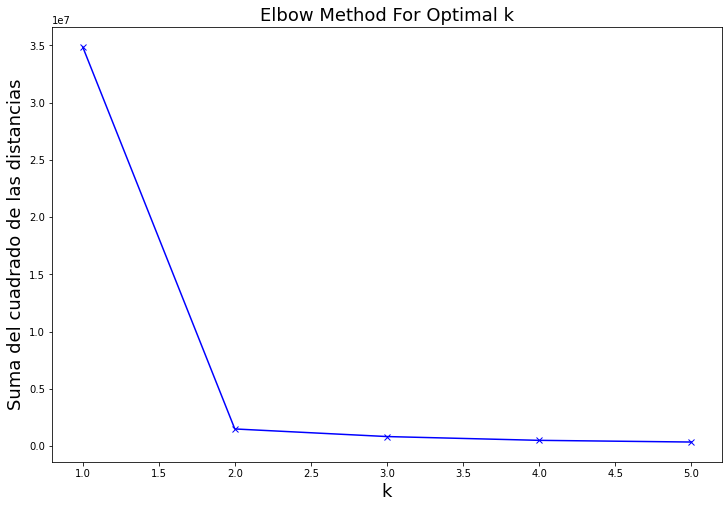

In [150]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(K, Sum_of_squared_distances,
        linestyle='-',
        color='blue',
        marker='x')

ax.set_xlabel('k', fontsize = 18)
ax.set_ylabel('Suma del cuadrado de las distancias', fontsize = 18)
ax.set_title('Elbow Method For Optimal k', fontsize = 18)

Podemos ver el quiebre en **k = 2** con lo cual vamos a elegir ese número de clúster.

Procedemos a fittear con ese valor nuestros datos almacenados en la matriz H

In [162]:
kmeans_aux = KMeans(n_clusters=2, random_state=0)
kmeans = kmeans_aux.fit(H)

Esto nos genera etiquetas para cada clúster realizado, que podemos ver con el método `.labels_`. Chusmeamos la forma que tiene:

In [152]:
kmeans.labels_.shape

(10000,)

Y ahora vamos a ver, en el espacio de los colores, cómo quedaron separados los elementos

Text(0.5, 0, 'Blue')

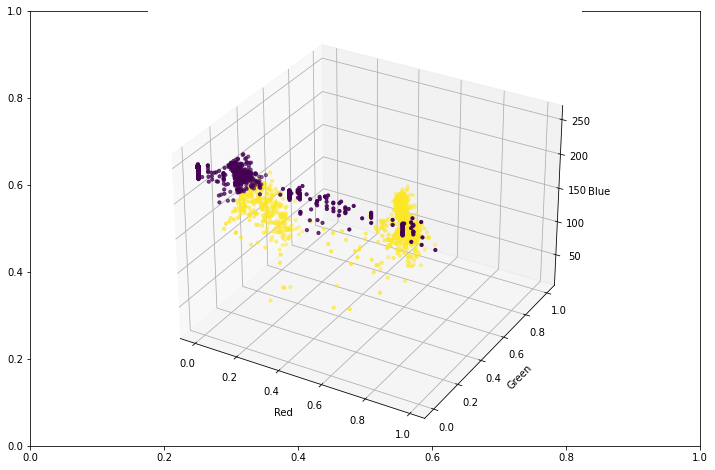

In [153]:
fig, ax3d = plt.subplots(figsize=(12, 8))
ax3D = fig.add_subplot(111, projection='3d')
ax3D.scatter( H[:, 0], H[:, 1], H[:, 2], 
             s=10, 
             c=kmeans.labels_, 
             marker='o')
ax3D.set_xlabel('Red')
ax3D.set_ylabel('Green')
ax3D.set_zlabel('Blue')

Finalmente, volvemos al espacio de nuestra imagen tratada y vemos qué quedó.

Text(0.5, 1.0, 'Imagen clusterizada')

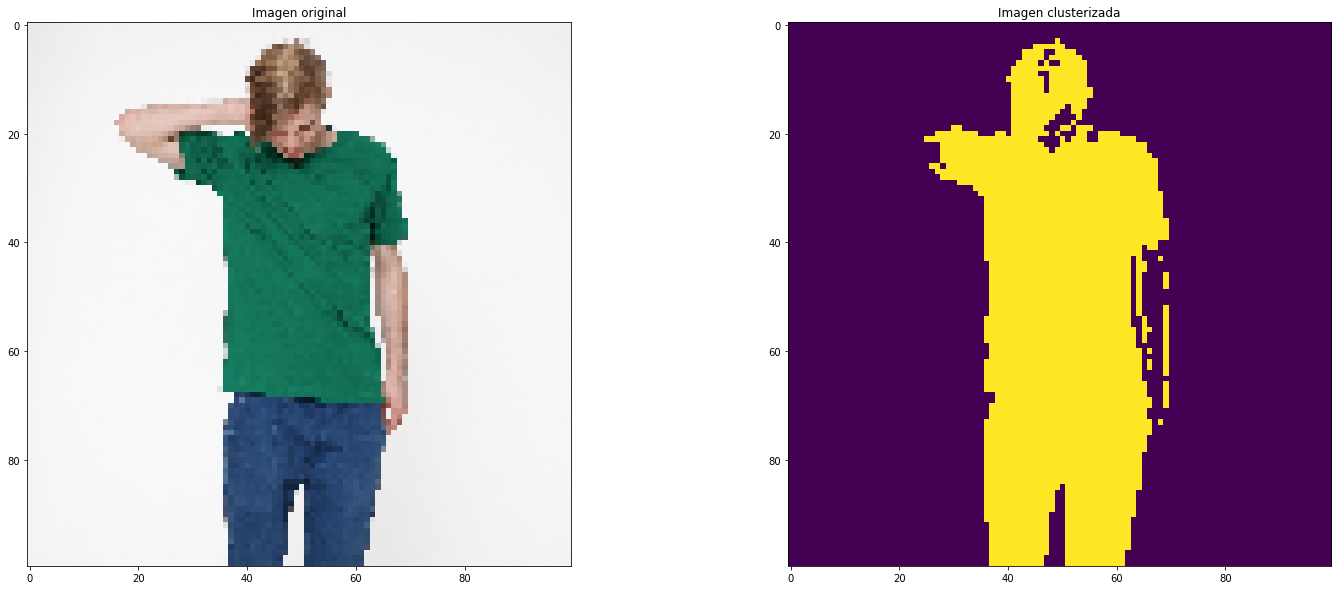

In [163]:
T = kmeans.labels_

mT = T.reshape(fil, col, order='F')

fig, ax = plt.subplots(1, 2, figsize=(25, 10))
ax[0].imshow(foto_red)
ax[0].set_title('Imagen original')
ax[1].imshow(mT)
ax[1].set_title('Imagen clusterizada')

Podemos ver que el algoritmo logró separar de manera efectiva la persona del fondo bastante bien a pesar de las limitaciones. Como último detalle vamos a probar con más clústers para ver qué pasa.

In [181]:
lista_labels = []
for i in range(2, 6):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(H)
    T = kmeans.labels_
    mT = T.reshape(fil, col, order='F')
    lista_labels.append(mT)

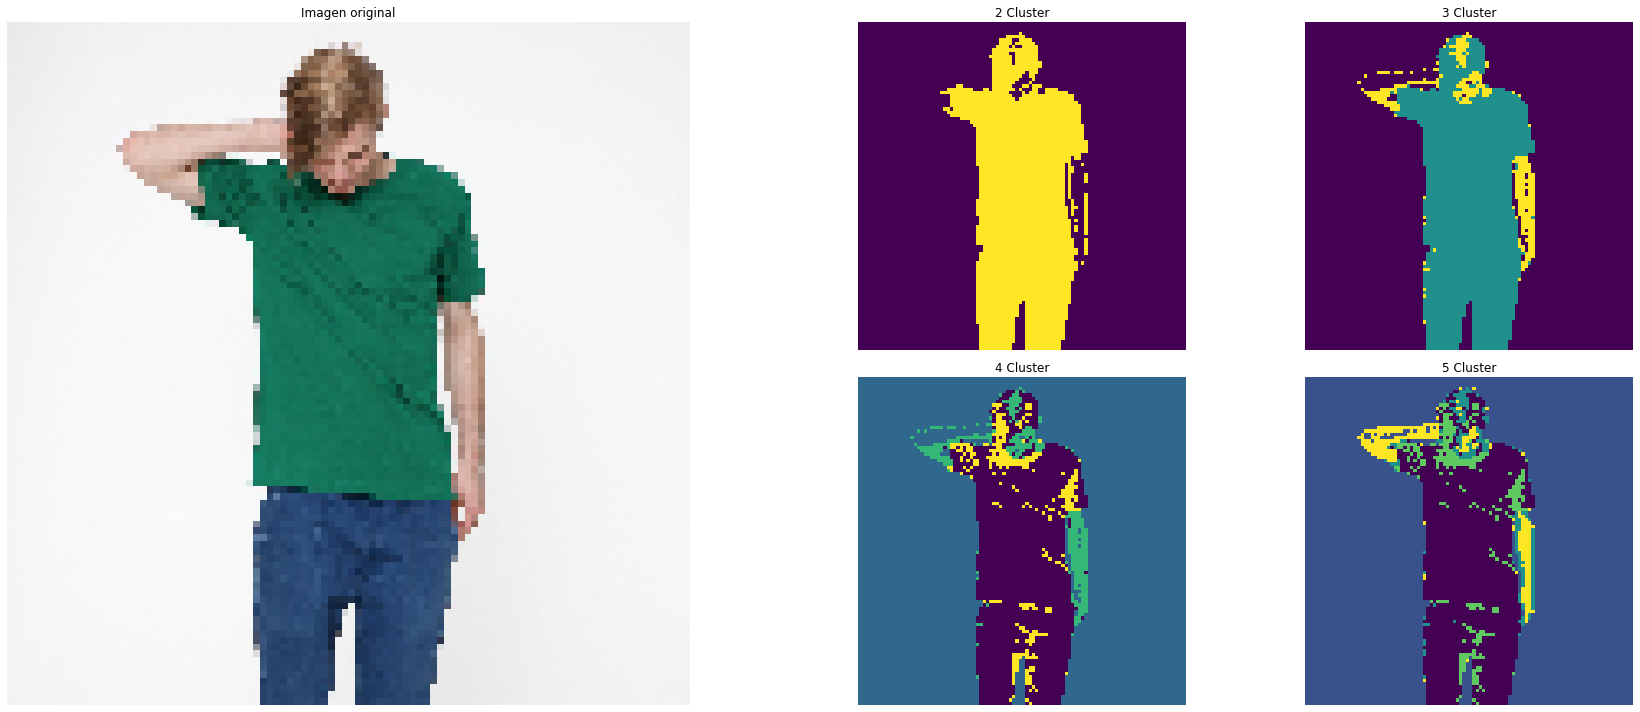

In [197]:
fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(foto_red)
ax.set_title('Imagen original')
ax.set_axis_off()

ax1 = fig.add_subplot(2, 4, 3)
ax1.imshow(lista_labels[0])
ax1.set_title('2 Cluster')
ax1.set_axis_off()

ax2 = fig.add_subplot(2, 4, 4)
ax2.imshow(lista_labels[1])
ax2.set_title('3 Cluster')
ax2.set_axis_off()

ax3 = fig.add_subplot(2, 4, 7)
ax3.imshow(lista_labels[2])
ax3.set_title('4 Cluster')
ax3.set_axis_off()

ax4 = fig.add_subplot(2, 4, 8)
ax4.imshow(lista_labels[3])
ax4.set_title('5 Cluster')
ax4.set_axis_off()

fig.tight_layout()

Podemos ver cómo con el aumento de número de clúster el algoritmo va encontrando más patrones para separar los elementos de la imagen, pero no resulta en una separación cada vez más exitosa, como se pudo ver en el gráfico de suma del cuadrado de las distancias vs el número de clúster.